<a href="https://colab.research.google.com/github/hhidayatinc/Machine_Learning/blob/main/Fake_News_Indo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [4]:
# Random seed for consistency
np.random.seed(42)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Label Encoder use to Encode target labels with value between 0 and n_classes-1
Encoder = LabelEncoder()

# TfidfVectorizer Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer()

In [7]:
# Baca data
data_train = pd.read_csv('/content/drive/MyDrive/dataset/uas/Data_latih.csv')
data_train.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [8]:
data_train['label'].value_counts()

1    3465
0     766
Name: label, dtype: int64

In [9]:
# Dari cell sebelumnya terlihat jelas bahwa dataset kita sangat tidak balance
# Untuk membuat datasetnya balance

# Pilih dataset dengan label 1 dan lakukan randomisasi untuk setiap baris datanya
false_news = data_train[data_train['label'] == 1].sample(frac=1)

# Concat dataset berlabel 1 yang telah dipilih dengan dataset berlabel 0
# dimana jumlah dataset berlabel 1 yang digabungkan sejumlah banyak dataset berlabel 0 + 200
true_fact = data_train[data_train['label'] == 0]
df = true_fact.append(false_news[:len(true_fact) + 200])

df

,ID,label,tanggal,judul,narasi,nama file gambar
19,6775,0,25-Oct-17,Sandi Sarankan Warga Ngadu ke Kelurahan Saja,Astaga! Sandiaga Sarankan Warga Ngadu ke Kelur...,6775.jpg
21,7038,0,13-Jul-17,"Irina, Istri Ahli IT Hermansyah disebut Mantan...","Irina, Istri Ahli IT Hermansyah disebut Mantan...",7038.jpg
22,7214,0,8-Mar-17,"Nezar Patria adalah Kader PKI, Ikut Rapat Seti...","Nezar Patria adalah Kader PKI, Ikut Rapat Seti...",7214.jpg
55,13483,0,17-Jul-18,Coach Indra Sjafri: Saya Pernah 1 Tahun Tak Di...,Kendati sukses mengantarkan Timnas Indonesia U...,13483.png
58,13907,0,28-Apr-18,Kronologis Polisi Berondong Sedan Terobos Razi...,"Innalillah… Hanya Karena Lalai Terobos Razia, ...",13907.png
...,...,...,...,...,...,...
1497,344135,1,17-Aug-20,Akun Facebook Wali Kota Payakumbuh Riza Falepi,Akun Facebook Wali Kota Payakumbuh “Riza Falepi”,344135.jpg
3109,734767,1,5-May-18,Harusnya Pak Fadli Zon Sadar,"Harusnya Pak Fadli Zon Sadar. Kami Paspampres,...",734767.jpg
3168,748029,1,19-Oct-19,"Ini Baru yang namanya Aksi Teroris Biadab, Kej...",Mengerikan Ini Baru yang namanya Aksi Teroris ...,748029.png
257,58725,1,13-Apr-20,Pesan Berantai PT MOSI Tawarkan Rapid Test Kit...,"Dear bapak/ibu dalam masa pandemic ini, kami P...",58725.jpg


In [10]:
# Kita akan menggunakan fitur narasi saja dalam melakukan prediksi terhadap label
feature = df['narasi']
label = df['label']

In [12]:
# Mengubah semua huruf pada setiap baris menjadi huruf kecil dan
# melakukan stemming pada setiap baris
lower = [stemmer.stem(row.lower()) for row in feature]

# Hasil stem dan lower
lower[:5]

['astaga sandiaga saran warga ngadu ke lurah saja tak perlu ke balai kota',
 'irina istri ahli it hermansyah sebut mantan psk',
 'nezar patria adalah kader pki ikut rapat tiap malam di istana telah jam 8 malam demikian tuduh dari alfian tandjung',
 'kendati sukses antar timnas indonesia u-19 juara piala aff u-19 2013 dan lolos ke putar final piala asia u-19 2014',
 'innalillah hanya karena lalai terobos razia mobil isi satu keluarga tembak polisi satu orang tewas']

In [13]:
# Melakukan tokenisasi untuk setiap baris dataset
tokens = [word_tokenize(element) for element in lower]

# Hasil tokenisasi setiap baris
tokens[:5]

[['astaga',
  'sandiaga',
  'saran',
  'warga',
  'ngadu',
  'ke',
  'lurah',
  'saja',
  'tak',
  'perlu',
  'ke',
  'balai',
  'kota'],
 ['irina', 'istri', 'ahli', 'it', 'hermansyah', 'sebut', 'mantan', 'psk'],
 ['nezar',
  'patria',
  'adalah',
  'kader',
  'pki',
  'ikut',
  'rapat',
  'tiap',
  'malam',
  'di',
  'istana',
  'telah',
  'jam',
  '8',
  'malam',
  'demikian',
  'tuduh',
  'dari',
  'alfian',
  'tandjung'],
 ['kendati',
  'sukses',
  'antar',
  'timnas',
  'indonesia',
  'u-19',
  'juara',
  'piala',
  'aff',
  'u-19',
  '2013',
  'dan',
  'lolos',
  'ke',
  'putar',
  'final',
  'piala',
  'asia',
  'u-19',
  '2014'],
 ['innalillah',
  'hanya',
  'karena',
  'lalai',
  'terobos',
  'razia',
  'mobil',
  'isi',
  'satu',
  'keluarga',
  'tembak',
  'polisi',
  'satu',
  'orang',
  'tewas']]

In [14]:
# train_test_split digunakan untuk memecah dataset menjadi 2 bagian
# X_train dan y_train mewakili data yang akan dilakukan pada fitting model(Training model)
# X_test dan y_test  mewakili data yang akan dilakukan pada evaluasi model
X_train, X_test, y_train, y_test = train_test_split(tokens, label, test_size=0.2, stratify=label)

In [15]:
# Melihat ukuran data latih dan data uji
print('X_train : ', len(X_train))
print('X_test : ', len(X_test))

X_train :  1385
X_test :  347


In [16]:
# Encoder for Data Label
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

y_train

array([1, 0, 0, ..., 1, 0, 1])

In [17]:
# Fitting dataset terhadap tf-idf
Tfidf_vect.fit(["".join(row) for row in X_train])

TfidfVectorizer()

In [18]:
# Mentransformasikan hasil fitting terhadap data X_train dan X_test
X_train_Tfidf = Tfidf_vect.transform([" ".join(row) for row in X_train])
X_test_Tfidf = Tfidf_vect.transform([" ".join(row) for row in X_test])

In [19]:
# Classifier - Algorithm - SVM
# fitting/training datasets pada algoritma SVM(Support Vector Machine)
SVM = svm.SVC(C=1.0, kernel='linear', degree=1, gamma="auto", verbose=True)
SVM.fit(X_train_Tfidf, y_train)  # predict the labels on validation dataset

# Menggunakan metrics accuracy untuk melihat performa model
predictions_SVM = SVM.predict(X_test_Tfidf)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)

[LibSVM]SVM Accuracy Score ->  58.21325648414985


In [20]:
rf = RandomForestClassifier()
rf.fit(X_train_Tfidf, y_train)

prediction_rf = rf.predict(X_test_Tfidf)
print("RandomForest Accuracy Score -> ", accuracy_score(prediction_rf, y_test)*100)

RandomForest Accuracy Score ->  56.48414985590778


accuracy:   0.573


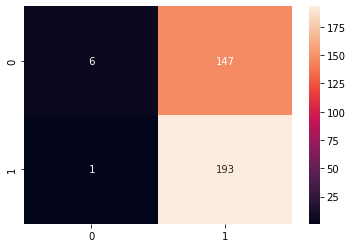

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import itertools
import seaborn as sns

classifier=MultinomialNB()
classifier.fit(X_train_Tfidf, y_train)
pred = classifier.predict(X_test_Tfidf)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True,fmt="2g")